In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import json
import os
import re
import sys
from glob import glob

import librosa
import matplotlib.pyplot as plt
import numpy as np
import yaml
from loguru import logger
from scipy.io import wavfile
from scipy.signal import get_window
from tqdm import tqdm

from enfify.config import ENFIFY_DIR, INTERIM_DATA_DIR
from enfify.enf_enhancement import RFA, VMD
from enfify.enf_estimation import (freq_estimation_DFT1,
                                   segmented_freq_estimation_DFT1,
                                   stft_pipeline)
from enfify.preprocessing import (bandpass_filter, downsample_ffmpeg,
                                  downsample_scipy)

Sample frequency: 44_100 Hz


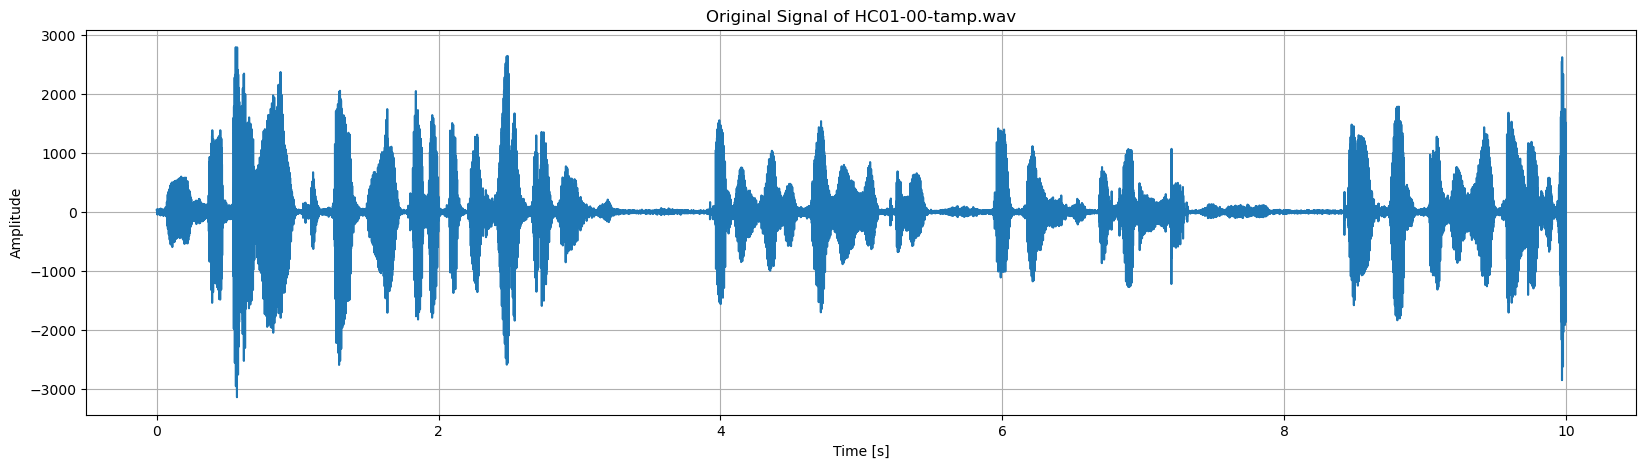

In [24]:
# LOADING
with open(ENFIFY_DIR/"config_nature.yml", "r") as f:
    config = yaml.safe_load(f)

with open(INTERIM_DATA_DIR / "Carioca1" / "cut_info.json", "r") as f:
    cut_info = json.load(f)

file = INTERIM_DATA_DIR / "Carioca1" / "HC01-00-tamp.wav"
sample_freq, sig = wavfile.read(file)
print(f"Sample frequency: {sample_freq:_} Hz")

# Plot the signal
time = np.arange(len(sig)) / sample_freq
plt.figure(figsize=(20, 5))
plt.plot(time, sig)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title(f"Original Signal of {file.name}")
plt.grid()
plt.show()

Downsampled frequency: 1_000 Hz


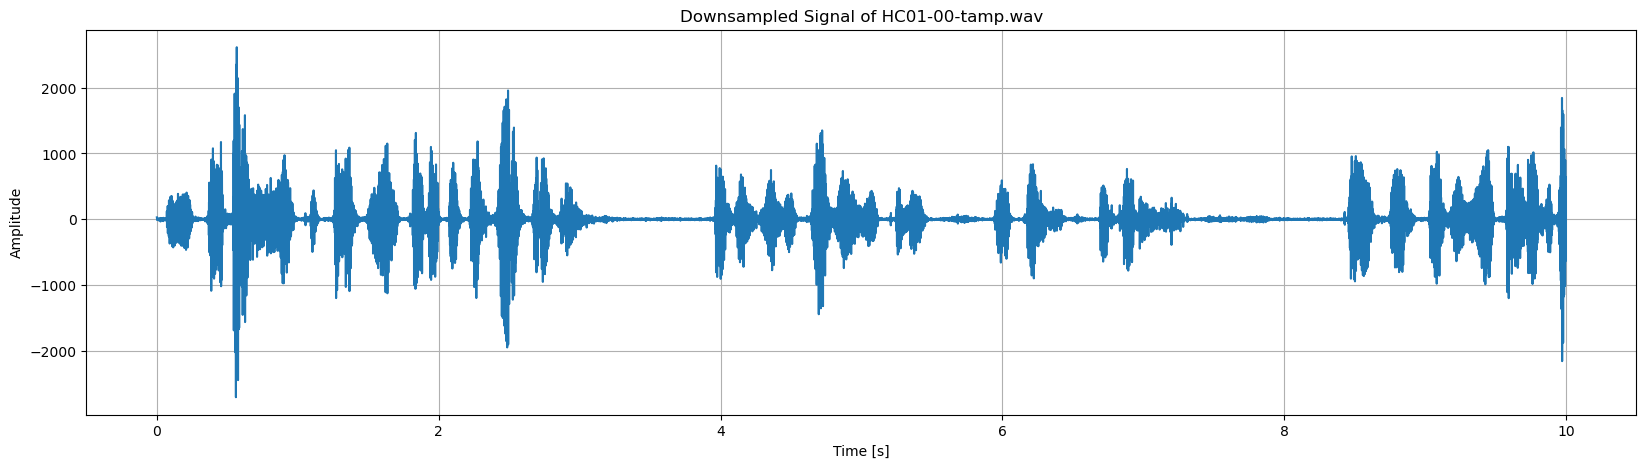

In [25]:
# FREQ_FEATURE_PIPELINE
# Downsampling
nominal_enf = config["nominal_enf"]
downsample_freq = config["downsampling_frequency_per_nominal_enf"] * nominal_enf
sig, downsample_freq = downsample_ffmpeg(sig, sample_freq, downsample_freq)
print(f"Downsampled frequency: {downsample_freq:_} Hz")

# Plot the signal
time = np.arange(len(sig)) / downsample_freq
plt.figure(figsize=(20, 5))
plt.plot(time, sig)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title(f"Downsampled Signal of {file.name}")
plt.grid()
plt.show()

Bandpass filter: 49.5 - 50.5 Hz
Filter order: 1


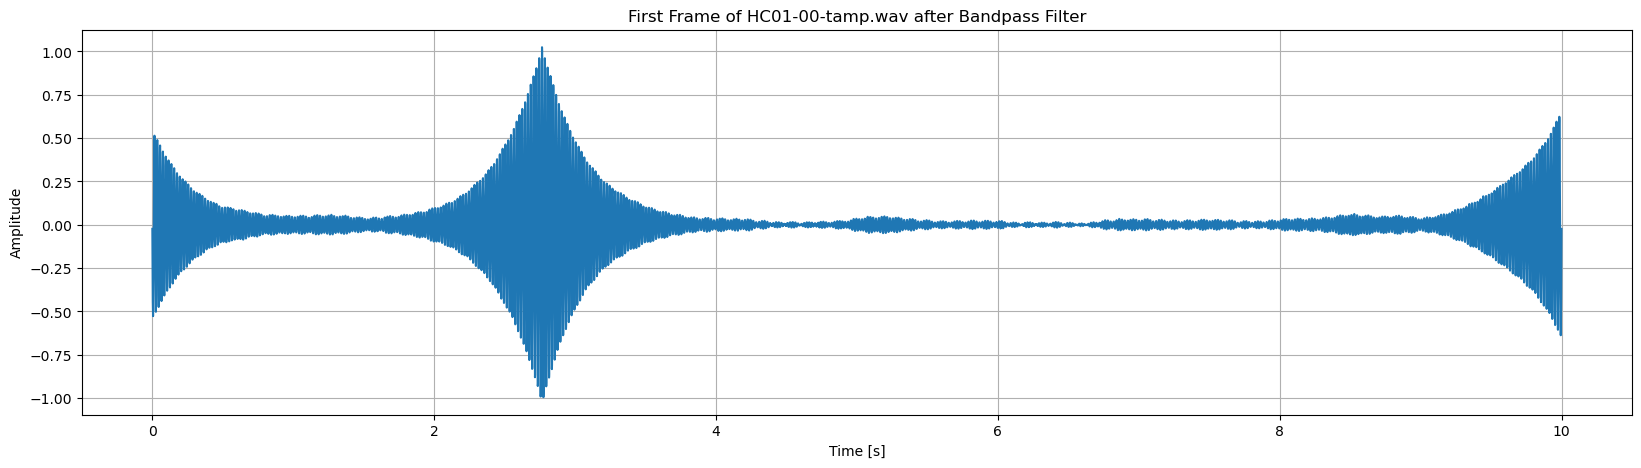

In [26]:
# Bandpass Filter
bandpass_config = config["bandpass_filter"]
lowcut = bandpass_config["lowcut"]
highcut = bandpass_config["highcut"]
order = bandpass_config["order"]
print(f"Bandpass filter: {lowcut} - {highcut} Hz")
print(f"Filter order: {order}")
sig = bandpass_filter(sig, lowcut, highcut, downsample_freq, order)

# Plot the first frame
plt.figure(figsize=(20, 5))
plt.plot(time, sig)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title(f"First Frame of {file.name} after Bandpass Filter")
plt.grid()
plt.show()


Number of frames: 335
Frame length: 300 samples


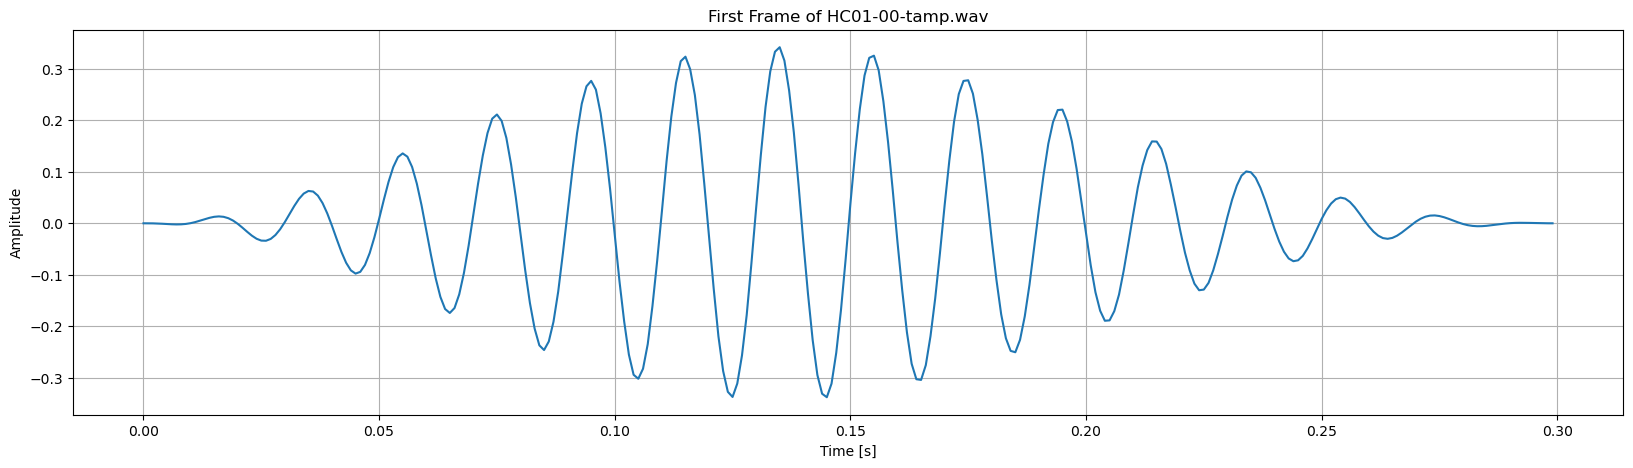

In [27]:
# Frame Splitting and Windowing
window_type = config["window_type"]
frame_len_samples = int(config["frame_len"] / 1000 * downsample_freq)
frame_shift = int(frame_len_samples * (1-config["frame_overlap"]))

num_frames = (len(sig) - frame_len_samples + frame_shift) // frame_shift
frames = np.zeros((num_frames, frame_len_samples))

window = get_window(window_type, frame_len_samples)
for i in range(num_frames):
    start = i * frame_shift
    end = start + frame_len_samples
    frames[i] = sig[start:end] * window

print(f"Number of frames: {num_frames}")
print(f"Frame length: {frame_len_samples} samples")

# Plot the first frame
time = np.arange(frame_len_samples) / downsample_freq
plt.figure(figsize=(20, 5))
plt.plot(time, frames[0])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title(f"First Frame of {file.name}")
plt.grid()
plt.show()


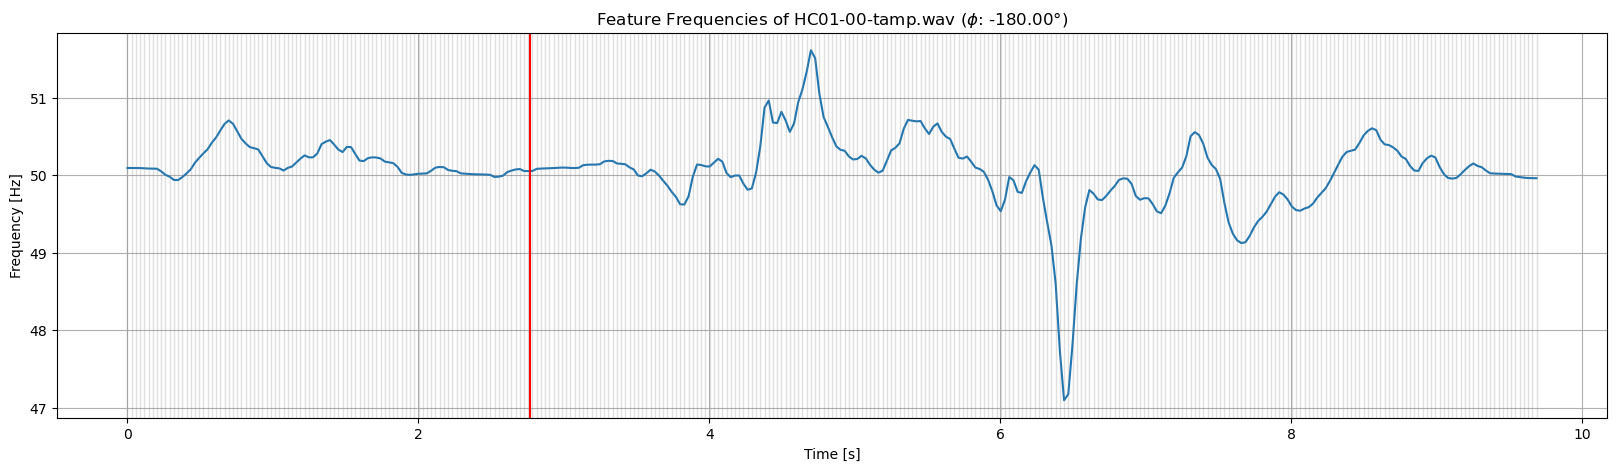

In [29]:
# Estimate the instantaneous frequency
freq_estimation_config = config["freq_estimation"]
n_dft = freq_estimation_config["n_dft"]

feature_freqs = [freq_estimation_DFT1(frame, downsample_freq, n_dft) for frame in frames]

# Plot the feature frequencies
time = np.arange(num_frames) * frame_shift / downsample_freq
plt.figure(figsize=(20, 5))
plt.plot(time, feature_freqs)
for i in range(num_frames):
    plt.axvline(i * frame_shift / downsample_freq, color="gray", lw=1, alpha=.25)
if "tamp" in file.name:
    start = cut_info[os.path.basename(file)]["start"]
    cutlen = cut_info[os.path.basename(file)]["cutlen"]
    plt.axvline(start / sample_freq, color="red")
    # calc cut phaseshift
    nominal_enf = config["nominal_enf"]
    phi = (cutlen / sample_freq / (1 / nominal_enf) * 360 + 180) % 360 - 180
    phi_info = f" ($\phi$: {phi:.2f}°)"
else:
    phi_info = ""
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
# plt.ylim(lowcut, highcut)
plt.title(f"Feature Frequencies of {file.name}{phi_info}")
plt.grid()
plt.show()